## Setup

In [ ]:
# setup - don't forget to use GPU runtime setting
!git clone https://github.com/ml-jku/Chem-xLSTM.git
!apt-get install -y -qq openbabel
!pip -q install rdkit prolif dask scikit-learn
%cd Chem-xLSTM
!pip install -e .

# download the pretrained models extract them and put them into models folder
!wget https://cloud.ml.jku.at/s/qpAS9iftYCN95by/download -O 'model.zip'
!unzip model.zip -d models
!unzip ./models/chem-xlstm-share/models.zip

## Few-Shot Conditinoal Generation with a pretrained model


In [2]:
# let's load the pretrained model
from chemxlstm import xLSTMforNTP, LSTMforNTP, MambaforNTP, GPTforNTP, xLSTMforNTP
import torch
import random

model_path = '/content/Chem-xLSTM/models/icst_pretrained/xLSTM-15.0M-ed512_hid64_l9_he8_500'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = xLSTMforNTP.from_file(model_path, n_heads=8, device=device) #n_ssm has to be set

/content/Chem-xLSTM/chemxlstm/module_library/kernel.py:604: SyntaxWarning: invalid escape sequence '\D'
  dt_min, dt_max: min and max values for the step size dt (\Delta)
/content/Chem-xLSTM/chemxlstm/module_library/cauchy.py:12: SyntaxWarning: invalid escape sequence '\s'
  returns: (..., L) \sum v/(z-w)


Loading model from /content/Chem-xLSTM/models/icst_pretrained/xLSTM-15.0M-ed512_hid64_l9_he8_500, using model class: xLSTMModel
Properties: {'mode': 'smiles', 'model_dim': 512, 'state_dim': 64, 'n_layers': 9, 'n_ssm': 1, 'dropout': 0.25, 'vocab_size': 200, 'sequence_length': 128, 'n_max_epochs': 100, 'learning_rate': 0.001, 'batch_size': 1, 'device': 'cuda:0', 'n_augmentations': 0, 'gpt_upj_factor': 4.0, 'kwargs': {}, 'warned_about_token': [], 'token2label': {'[PAD]': 0, '[BEG]': 1, 'C': 2, 'c': 3, '1': 4, '(': 5, '=': 6, 'O': 7, ')': 8, 'n': 9, '-': 10, '2': 11, '.': 12, 'Cl': 13, 'N': 14, '3': 15, 'S': 16, '/': 17, '[': 18, '+': 19, ']': 20, 'P': 21, '@': 22, 'H': 23, 'o': 24, 'F': 25, 'Br': 26, '#': 27, '4': 28, '5': 29, 'Na': 30, '6': 31, '7': 32, 's': 33, 'Si': 34, 'I': 35, 'K': 36, 'Au': 37, 'Pt': 38, 'Se': 39, 'Fe': 40, '8': 41, 'se': 42, 'Li': 43, '[END]': 44, 'B': 45, '9': 46, 'Cu': 47, 'Te': 48, 'As': 49, 'Ni': 50, 'Sb': 51, 'Ba': 52, 'Mn': 53, 'Ag': 54, 'Pb': 55, 'Eu': 56, '

In [19]:
# in the context put in the few samples form a distribution of SMILES molecules from which you want the designs to come from
context = 'CCCCN(C(=O)NC(=O)Nc1nc2ccc(OC)cc2s1)S(C)(=O)=O.COc1ccc(/C=C/C(=O)Nc2cccc(C(C)=O)c2)cc1.C=c1ccc2c(O)c(O)c3ccc(=C)c(C)c3c2c1C.O=C1C=C(N2CCOCC2)c2ccccc2C1=O.COc1cc2c(ccc3cc(OC)c(OC)c(O)c32)cc1O.CC1(C)Oc2ccc3ccc(=O)oc3c2-c2c[nH]nc21' # SMILES seperated by '.'
# using these 6 molecules we generate new molecules
# add '.' at the end so it generates a new molecule automatically (otherwise it might add something to the last molecule ;)
context += '.' if not context.endswith('.') else ''

# you can also do augmentation by shuffeling the molecules
generated_molecules = []
for n in range(2): # we do this 2 times (arbitrary)
  # lets do permutation-augmentation (you can also increase temperature to get more randomness)
  c = context.split('.')[:-1]
  random.shuffle(c)
  context = '.'.join(c)+'.'
  # and let's design some molecules and take the first after the context
  seq, ll = model.design_molecules(n_designs=128, batch_size=128, temperature=1.0, context=context, debug=False, sequence_length=500) # adjust the seqence lenth to the number of molecules and your results
  for s in seq:
    generated_molecules.append(s[len(context):].split('.')[0])

100%|██████████| 1/1 [00:23<00:00, 23.79s/it]


In [23]:
len(set(generated_molecules)), len(generated_molecules)

(232, 256)

In [ ]:
# SMILES unique valid molecules from our generated ones
valid_generated_mols = list(set(list(filter(lambda x: Chem.MolFromSmiles(x) is not None, generated_molecules))))

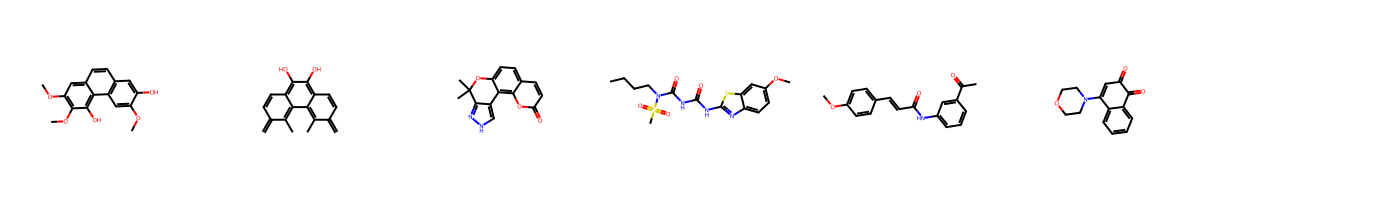

In [40]:
# let's view the context / the few-shot examples
from rdkit import Chem
from rdkit.Chem import Draw
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(smiles) for smiles in context.split('.')], molsPerRow=7, subImgSize=(200, 200))
display(img)

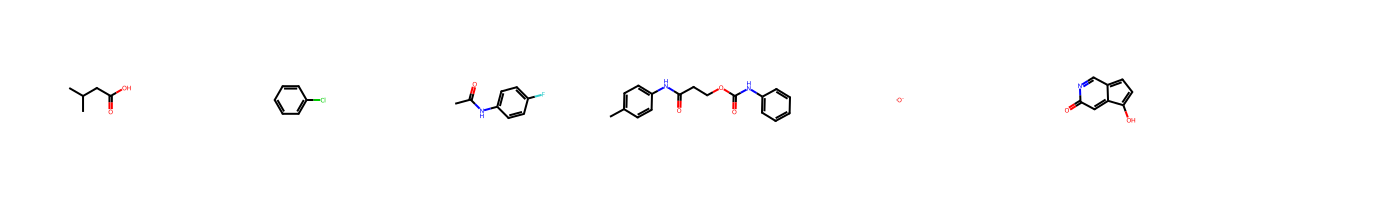

In [42]:
# and the designs from our pretrained model (only the first 6)
display(Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in valid_generated_mols[:6]], molsPerRow=7, subImgSize=(200, 200)))

In [44]:
# you can get a sample from the test-set of the ICST and perform further tests =)
import pandas as pd
d_test = pd.read_csv('https://github.com/ml-jku/Chem-xLSTM/raw/refs/heads/main/data/icst/test.zip', header=None)#.sample(1).iloc[0,0]
d_test.head(2)

,0
0,CC1=NC=C(C(=C1O)CO)CO.Cl.C1CCC(C1)[NH-].[NH2-]...
1,CCNc1nc(Nc2cc(F)c(C(=O)N3CCOCC3)cc2OC)ncc1C(F)...
